**import dataset**

In [1]:
!git clone https://github.com/elaamranisoufiane/2018CompDatasetNormClean.git

Cloning into '2018CompDatasetNormClean'...
remote: Enumerating objects: 1340, done.
remote: Counting objects: 100% (1340/1340), done.
remote: Compressing objects: 100% (1332/1332), done.
remote: Total 1340 (delta 9), reused 1339 (delta 8), pack-reused 0
Receiving objects: 100% (1340/1340), 16.12 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

 

**performance metrics**


In [3]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

**Our Model**


In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    s = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(s)
    return s, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """ Input layer """
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    #add layer
    s5, p5 = encoder_block(p4, 512)
    

    """ Bottleneck """
    b1 = conv_block(p5, 1024)

    """ Decoder """
    #add layer
    d0 = decoder_block(b1, s5, 512)
    
    d1 = decoder_block(d0, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    """ Output layer """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

if __name__ == "__main__":
    model = build_unet((256, 256, 3))
    model.summary()

2023-02-04 19:36:42.488200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 19:36:42.621206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 19:36:42.621979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 19:36:42.623927: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [5]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
#import build_unet
#import dice_coef, iou


# input image size
H = 256
W = 256


# create directory and gives the path
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)


def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x


def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks", "*.jpg")))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)
    # create a file in the same ocation
    create_dir('files')
    """ Hyperparaqmeters """
    batch_size = 8
    lr = 1e-4  ## 0.0001
    num_epochs = 120
    model_path = "files/model.h5"
    csv_path = "files/data.csv"
    """ Dataset """
    #dataset_path = "./DBA"
    # colab
    # dataset_path = "/content/U-Net-for-Nuclei-Semantic-Segmentation/DSB"
    # kuggle
    dataset_path = "./2018CompDatasetNormClean"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffle(train_x, train_y)
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    train_steps = (len(train_x) // batch_size)
    valid_steps = (len(valid_x) // batch_size)

    if len(train_x) % batch_size != 0:
        train_steps += 1
    if len(valid_x) % batch_size != 0:
        valid_steps += 1

    for x, y in valid_dataset:
        print(x.shape, y.shape)
        break
    """ build the model with U-Net network archtecture """
    model = build_unet((H, W, 3))
    metrics = ["accuracy", dice_coef, iou, Recall(), Precision()]
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr), metrics=metrics)
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks,
        shuffle=False
    )

Train: 399 - 399
Valid: 132 - 132
Test: 132 - 132


2023-02-04 19:36:46.501044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(8, 256, 256, 3) (8, 256, 256, 1)
Epoch 1/120


2023-02-04 19:36:51.197516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 20s 178ms/step - loss: 0.5496 - accuracy: 0.7118 - dice_coef: 0.3270 - iou: 0.1982 - recall: 0.7298 - precision: 0.4359 - val_loss: 0.6632 - val_accuracy: 0.6358 - val_dice_coef: 0.2247 - val_iou: 0.1278 - val_recall: 0.1517 - val_precision: 0.1587

Epoch 00001: val_loss improved from inf to 0.66319, saving model to files/model.h5
Epoch 2/120
50/50 [==============================] - 6s 130ms/step - loss: 0.3538 - accuracy: 0.8614 - dice_coef: 0.4501 - iou: 0.2932 - recall: 0.7176 - precision: 0.7862 - val_loss: 0.6069 - val_accuracy: 0.7345 - val_dice_coef: 0.2214 - val_iou: 0.1255 - val_recall: 0.0309 - val_precision: 0.1002

Epoch 00002: val_loss improved from 0.66319 to 0.60695, saving model to files/model.h5
Epoch 3/120
50/50 [==============================] - 6s 129ms/step - loss: 0.2826 - accuracy: 0.8796 - dice_coef: 0.4978 - iou: 0.3345 - recall: 0.6748 - precision: 0.8818 - val_loss: 0.5486 - val_accuracy: 0.7335 - val_dice_coef: 0.2178

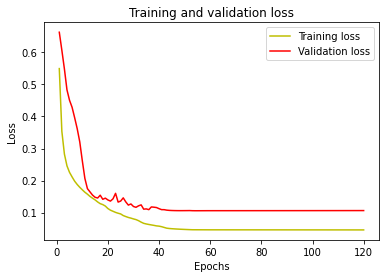

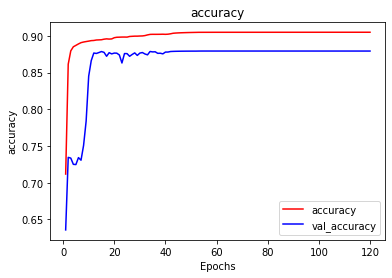

In [7]:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()
    #plt.imshow(mpimg.imread('./loss.png'))

    accu = history.history['accuracy']
    val_accu = history.history['val_accuracy']
    epochs = range(1, len(accu) + 1)
    plt.plot(epochs, accu, 'r', label='accuracy') 
    plt.plot(epochs, val_accu, 'b', label='val_accuracy') 
    plt.title('accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()
    #plt.imshow(mpimg.imread('./accuracy.png'))

In [8]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
#import dice_coef, iou
#import load_data

H = 256
W = 256


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)  ## (1, 256, 256, 3)
    return ori_x, x


def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x / 255.0
    x = x > 0.5
    x = x.astype(np.int32)
    return ori_x, x


def save_result(ori_x, ori_y, y_pred, save_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_path, cat_images)


if __name__ == "__main__":
    create_dir("results")

    """ Load Model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model("files/model.h5")
        #model.summary()

    """ Dataset """
    dataset_path = "./2018CompDatasetNormClean"
    #dataset_path = "/imagesToAugment/images"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    """ Prediction and metrics values """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        """ Reading the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        """ Prediction """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        save_path = f"results/{name}"
        save_result(ori_x, ori_y, y_pred, save_path)

        """ Flattening the numpy arrays. """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """ Saving all the results """
    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

100%|██████████| 132/132 [00:16<00:00,  8.18it/s]

Accuracy: 0.97282
F1: 0.90028
Jaccard: 0.82471
Recall: 0.92162
Precision: 0.88864


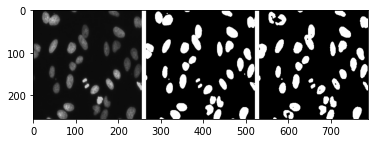

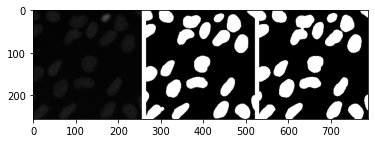

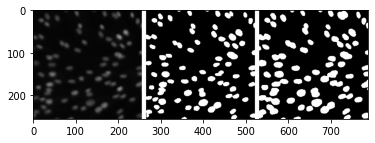

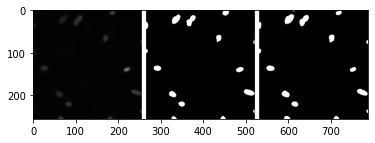

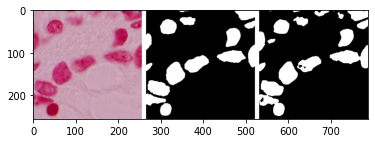

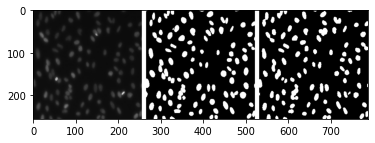

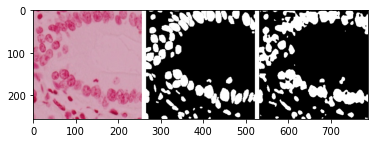

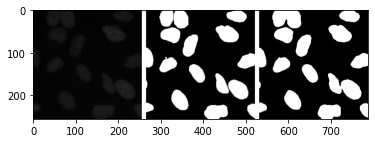

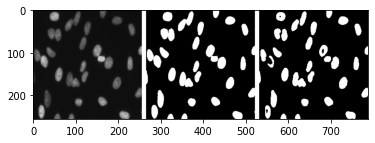

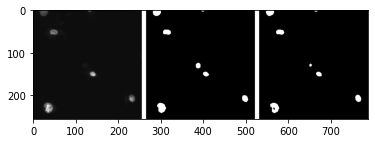

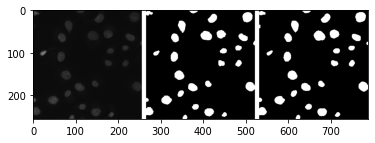

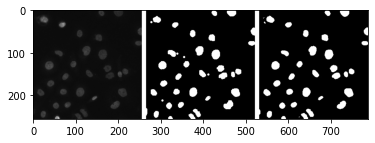

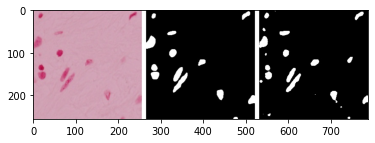

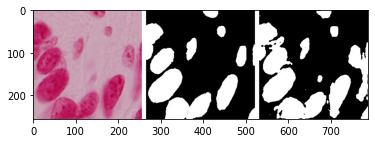

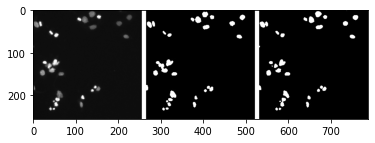

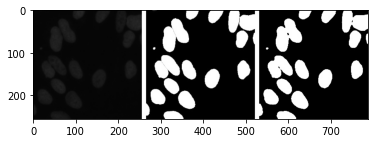

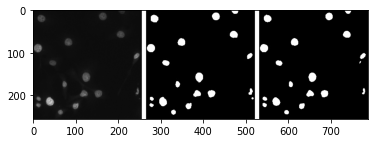

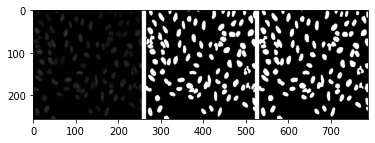

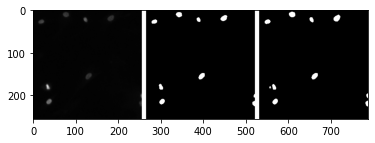

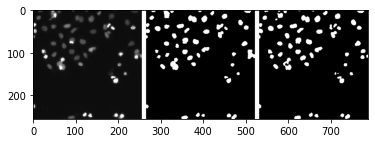

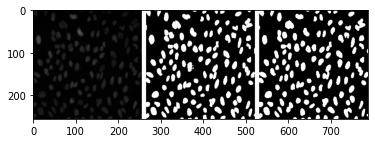

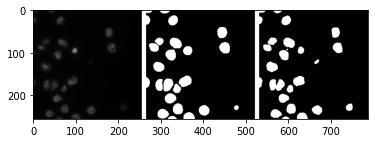

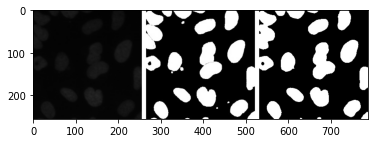

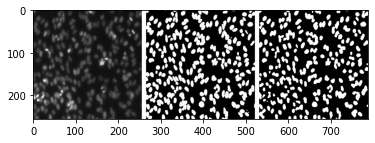

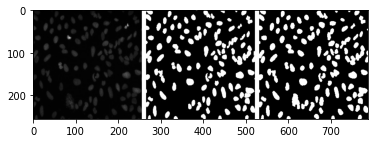

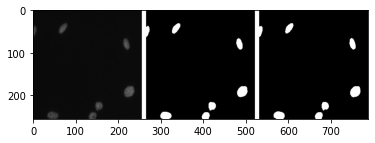

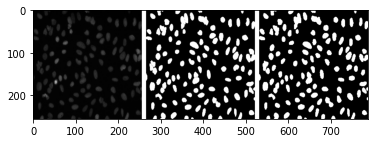

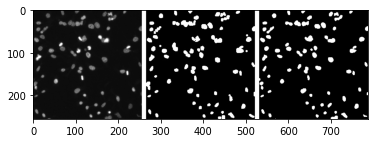

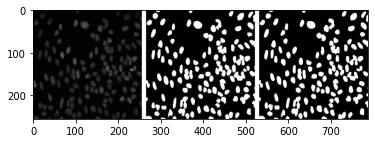

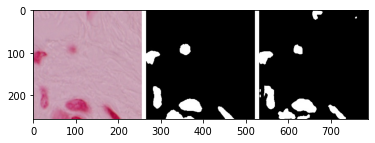

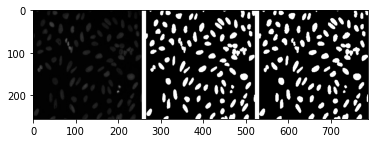

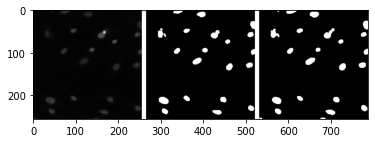

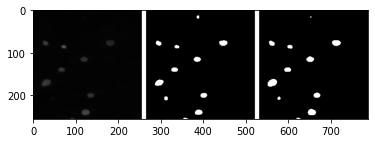

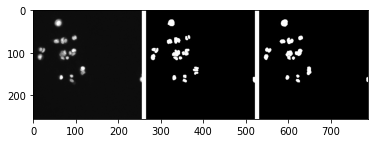

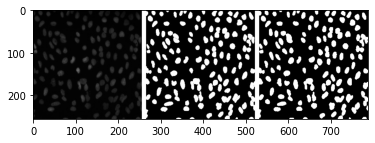

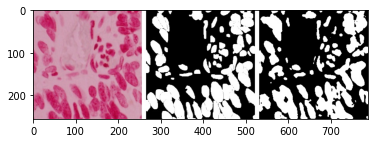

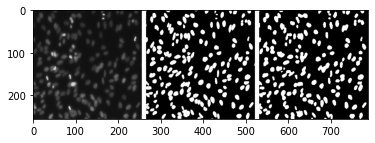

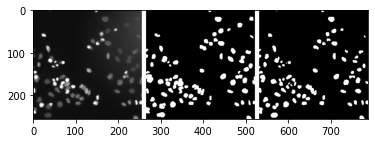

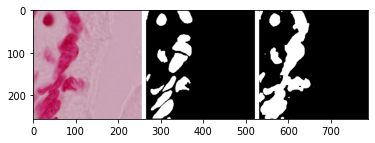

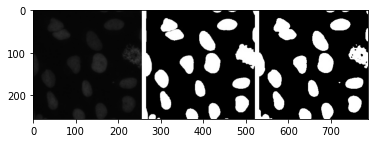

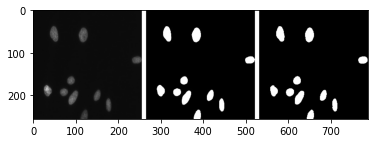

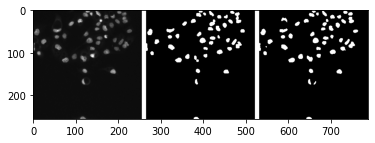

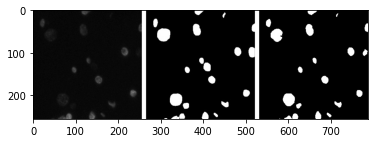

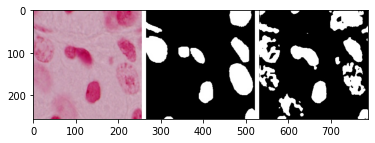

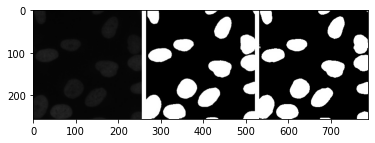

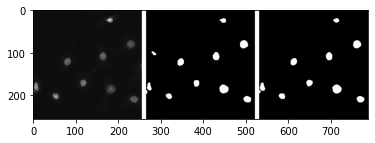

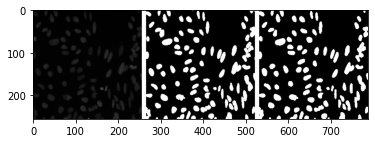

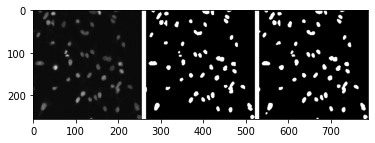

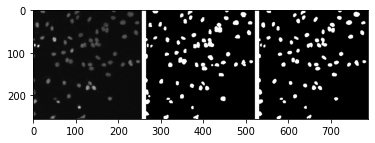

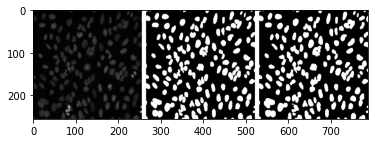

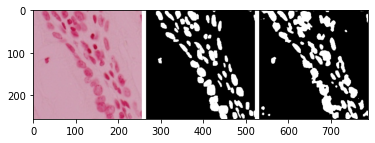

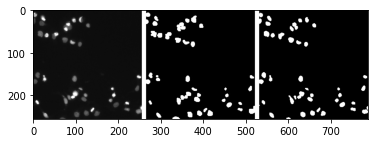

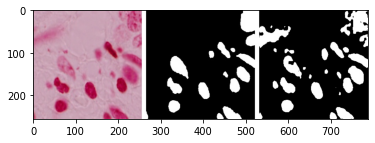

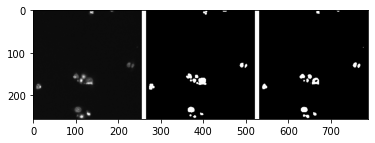

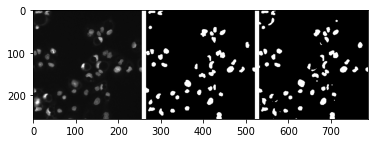

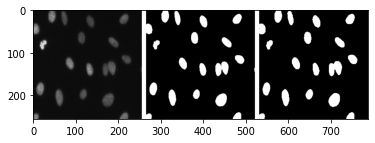

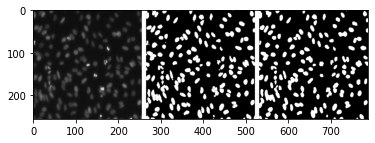

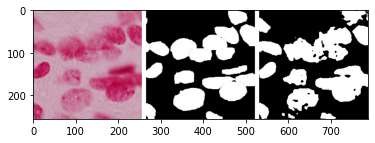

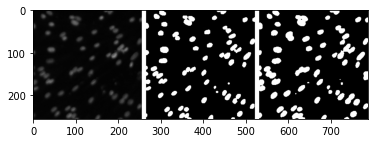

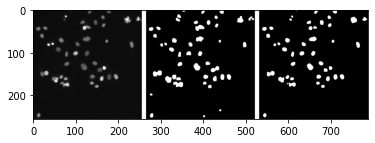

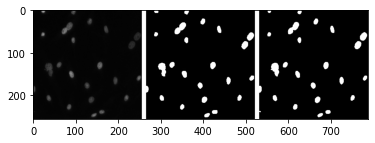

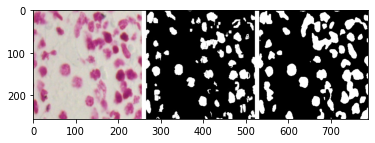

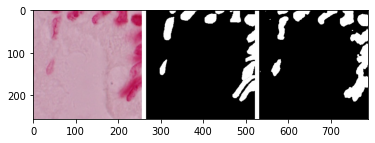

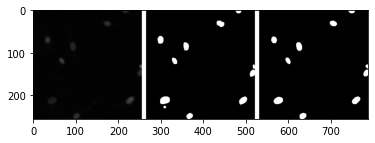

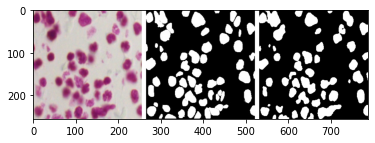

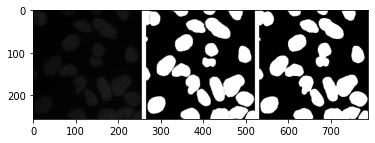

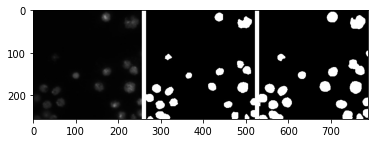

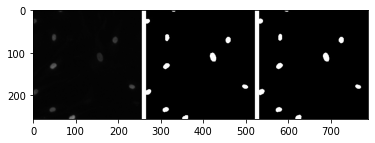

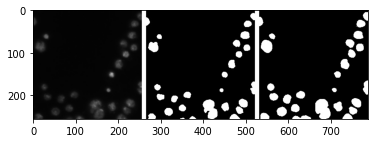

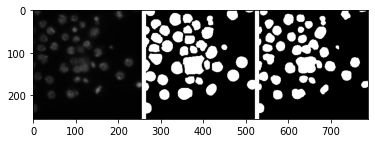

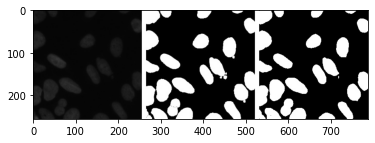

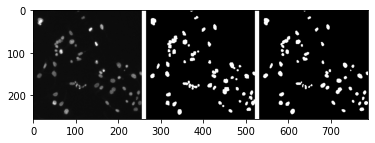

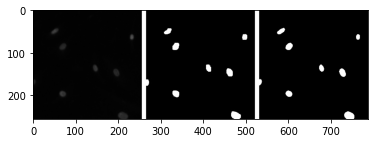

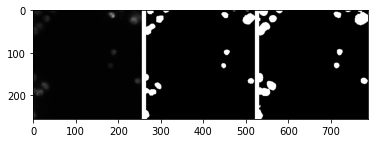

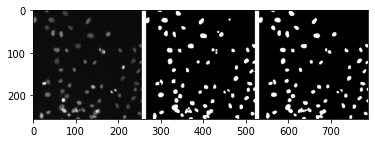

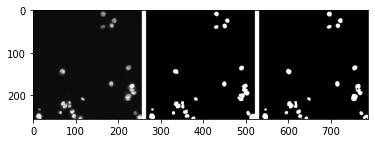

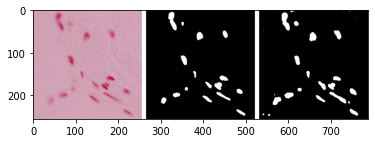

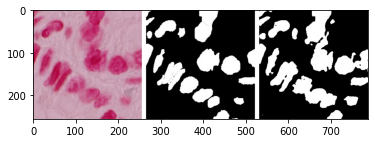

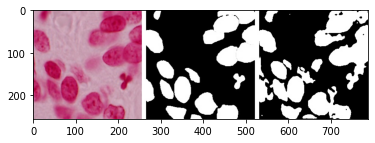

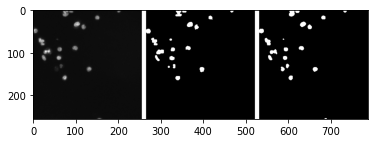

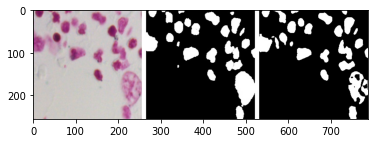

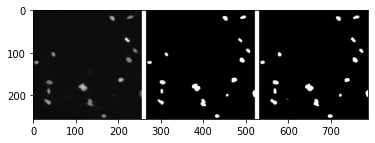

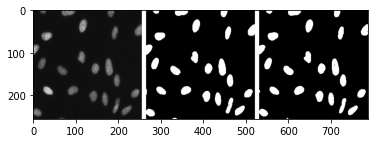

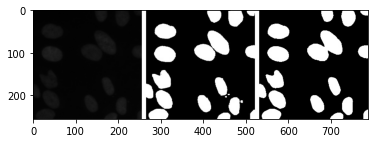

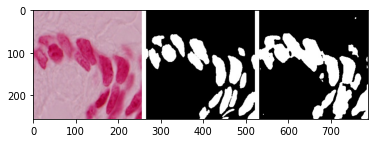

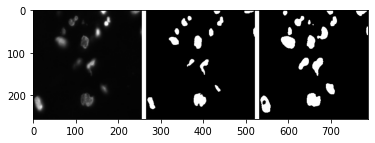

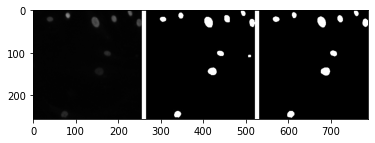

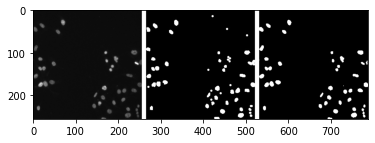

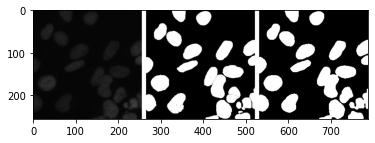

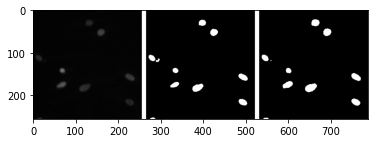

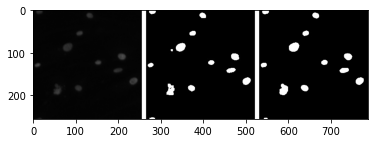

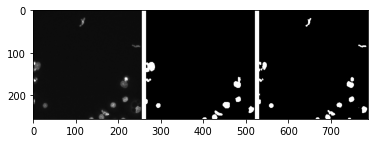

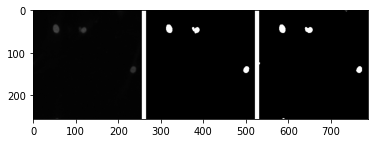

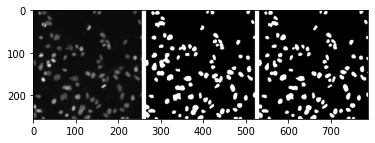

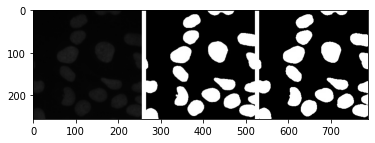

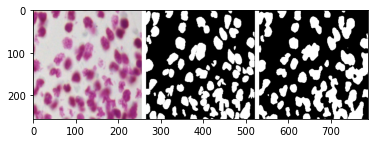

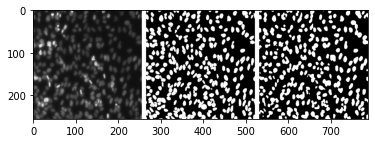

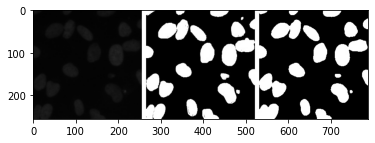

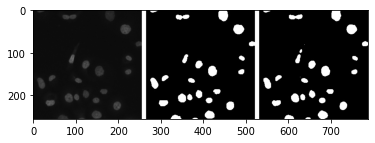

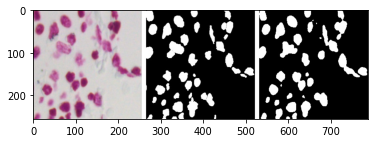

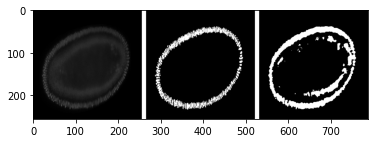

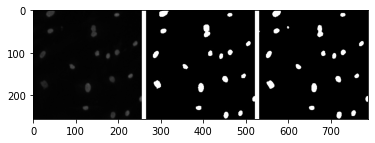

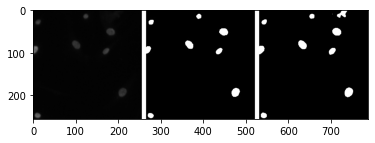

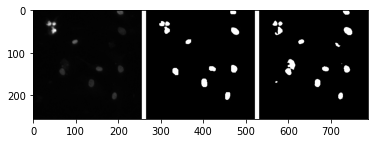

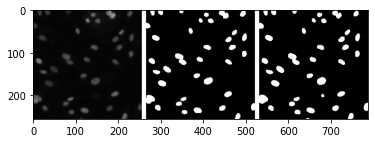

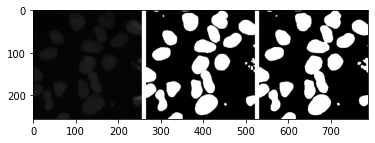

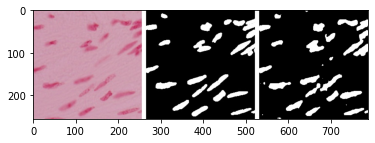

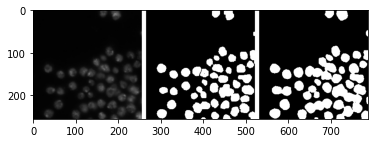

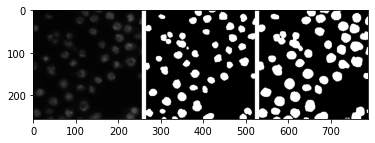

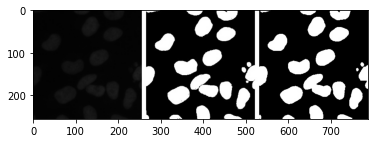

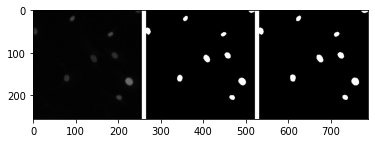

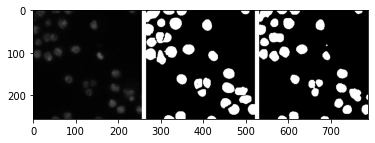

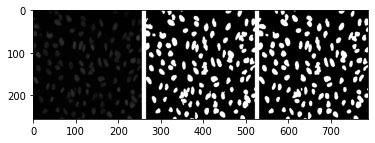

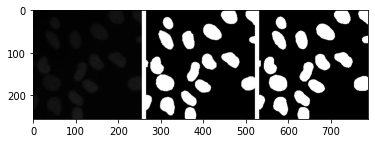

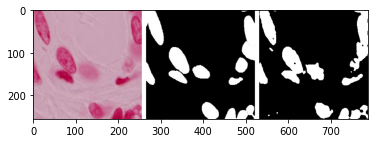

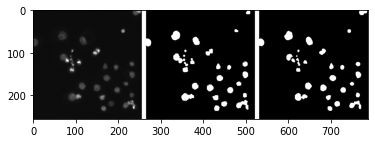

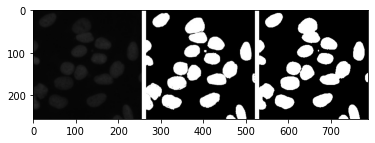

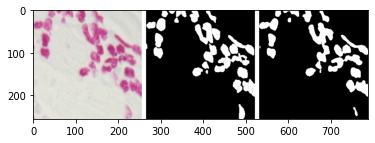

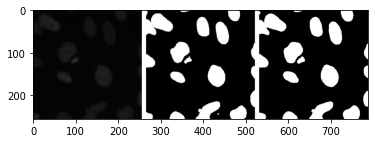

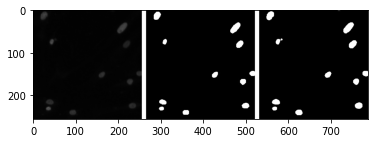

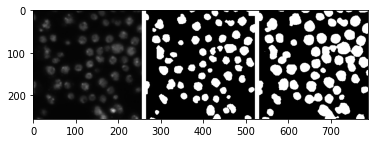

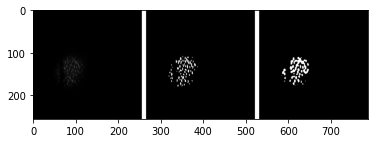

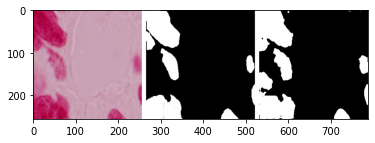

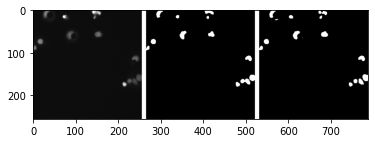

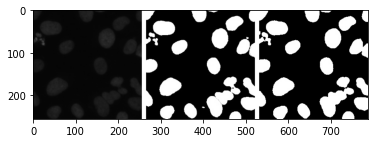

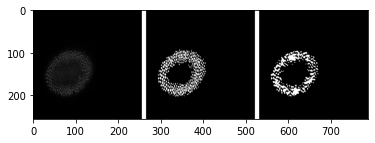

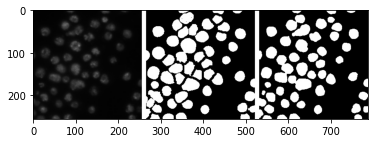

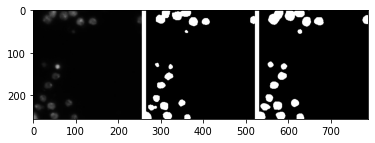

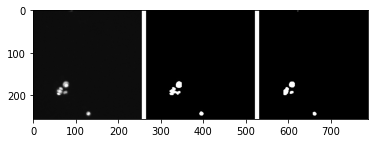

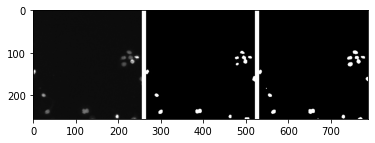

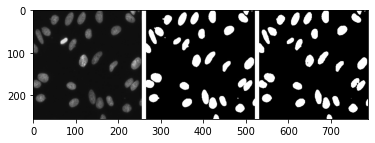

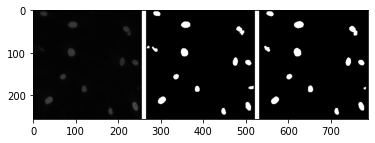

In [9]:
import cv2
import glob
import matplotlib.pyplot as plt
    
path="./results/*.jpg"

images=[cv2.imread(image) for image in glob.glob(path)]
fig=plt.figure()
for i in range(len(images)):
    #plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.show()

In [10]:
!zip -r ./file.zip ./results 

  adding: results/ (stored 0%)
  adding: results/4e1c889de3764694d0dea41e5682fedb265eaf2cdbe72ff6c1f518747d709464.jpg (deflated 5%)
  adding: results/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a.jpg (deflated 5%)
  adding: results/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e.jpg (deflated 5%)
  adding: results/4b274461c6d001a7a9aeaf5952b40ac4934d1be96b9c176edfd628a8f77e6df2.jpg (deflated 14%)
  adding: results/4d4f254f3b8b4408d661df3735591554b2f6587ce1952928d619b48010d55467.jpg (deflated 5%)
  adding: results/351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c.jpg (deflated 3%)
  adding: results/3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940.jpg (deflated 3%)
  adding: results/57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344.jpg (deflated 5%)
  adding: results/449f41710769584b5e4eca8ecb4c76d5272605f27da2949e6285de0860d2cbc0.jpg (deflated 5%)
  adding: results/6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2c

In [11]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip